### Importing libraries

In [6]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from collections import Counter

### Verifying raw data path
If assertion fails, download the movielens-100k ratings data from [konect](http://konect.cc/networks/movielens-100k_rating/) and put the files in data/raw.

In [12]:
raw_data_path ="data/raw/"
figure_path = "data/figures/"
bipartite_path = "data/bipartite/full_bipartite.p"

assert os.path.exists(raw_data_path)

### Create/load the bipartite network

In [13]:
if os.path.exists(bipartite_path):
    with open(bipartite_path, 'rb') as f:
        G = pickle.load(f)
    print("Graph loaded")
else:
    G = nx.Graph()
    
    with open(raw_data_path+"rel.rating.csv", 'r') as f:
        movie_ids = set()
        user_ids = set()
        edges = []
        for line in f.readlines():
            userid, movieid, rating, timestamp = tuple(map(int, line.strip().split(' ')))
            movie_ids.add(movieid)
            userid += 10000
            user_ids.add(userid)
            edges.append((userid, movieid, rating))  # Discarding the timestamp attribute of edges

    G.add_nodes_from(user_ids, bipartite=0)
    G.add_nodes_from(movie_ids, bipartite=1)
    G.add_weighted_edges_from(edges)

    with open(bipartite_path, 'wb') as f:
        pickle.dump(G, f)
    print("Graph created and saved")

Graph loaded


These are summary statistics of the graph from running scripts/metrics.py (removed irrellevant statistics):

#### Basic Statistics
Number of Nodes: 2625, Number of Edges: 100000, Global Density: 0.029, Global Diameter: 5 

####  Degree Statistics
Average Degree: 76.19, Five-Number-Summary Degrees: [  1.,  15.,  42., 106., 737.]

#### Connected Components Statistics
Number of CC: 1, Average CC Size: 2625.0, Average CC Density: 0.029036004645760744}, 

### Weight (Rating) Distribution

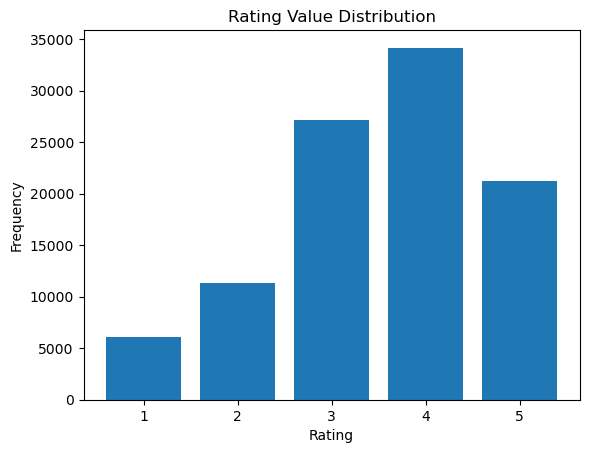

In [15]:
weights = list(edge[2]['weight'] for edge in G.edges(data=True))
unique, count = np.unique(weights, return_counts=True)
plt.bar(unique, count)
plt.title("Rating Value Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency");
np.mean(weights), np.std(weights)
plt.savefig(figure_path+"bipartite_rating_value_distribution.png")

### Degree Distribution

In [21]:
def plot_ccdf(degree_dictionary):  # takes dict(G.degree)
   dd = Counter(degree_dictionary.values())
   dd = pd.DataFrame(list(dd.items()), columns = ("degree", "count")).sort_values(by = "degree")
   ccdf = dd.sort_values(by = "degree", ascending = False)
   ccdf["cumsum"] = ccdf["count"].cumsum()
   ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
   ccdf = ccdf[["degree", "ccdf"]].sort_values(by = "degree")
   return ccdf

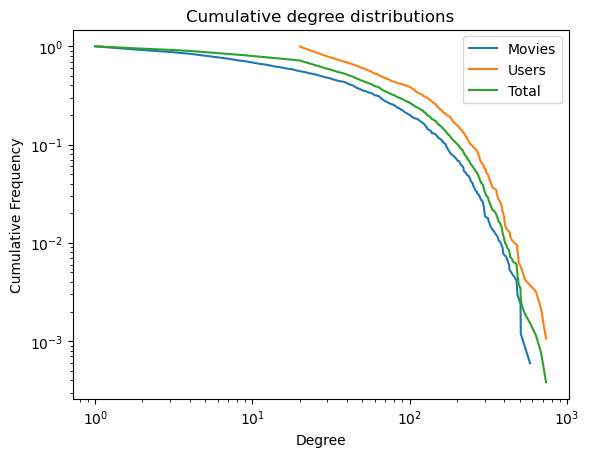

In [23]:
movie_degrees = {k:v for k,v in dict(G.degree()).items() if k < 10000}
user_degrees = {k:v for k,v in dict(G.degree()).items() if k >= 10000}

movie_ccdf = plot_ccdf(movie_degrees)
user_ccdf = plot_ccdf(user_degrees)
total_ccdf = plot_ccdf(dict(G.degree()))

ax = plt.gca()
                       
movie_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Movies', ax=ax)
user_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Users', ax=ax);
total_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Total', ax=ax);

ax.set_title("Cumulative degree distributions")                       
plt.ylabel("Cumulative Frequency")
plt.xlabel("Degree")
                       
plt.savefig(figure_path+"bipartite_ccdf_movies_and_users.png")

In [23]:
min(user_degrees.values()), min(movie_degrees.values()), float(1-movie_ccdf[movie_ccdf['degree'] == 20]['ccdf'])

(20, 1, 0.4417360285374554)

The distributions are not power law; they are shifted and there is exponential cutoff. 20 is the obvious minumum of movies rated by any user, since users with fewer than 20 ratings were discarded when making the data set. Some movies on the other hand have very few ratings, the minimum being 1. 44% of movies are rated by 20 or less people.

Add for next time:
add degree distribution plots
summary statistics 
check for power low